HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

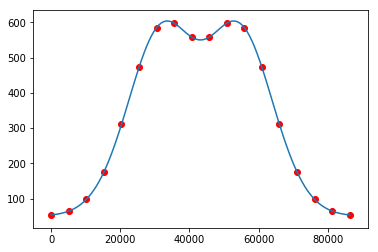

In [2]:
total_seconds = 24 * 3600
total_rps = 1000

def gaussian(x, mu = 0, sig = 1):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def rps(x):
  return (gaussian(x, total_seconds/2, 12000) * 5 - gaussian(x, total_seconds/2, 10000) * 4 ) * 500 + 50

def fake_train(batch_size=100):
  x = np.linspace(0, total_seconds, batch_size)
  return x, rps(x)

x = np.linspace(0, total_seconds, 120)
plt.plot(x, rps(x))
plt.scatter(fake_train(18)[0], fake_train(18)[1], color='red')
plt.show()

Function to generate a training batch:

In [3]:
def secs_to_time(time_in_seconds):
  hours = time_in_seconds // 3600
  minutes = (time_in_seconds - hours * 3600) // 60
  seconds = time_in_seconds - hours * 3600 - minutes * 60
  return hours, minutes, seconds

def time_to_secs(hour, minutes, seconds):
  return hour * 3600 + minutes * 60 + seconds

def time_to_squashed_secs(hour, minutes, seconds):
  return time_to_secs(hour, minutes, seconds) / total_seconds

def secs_to_string(sec):
  result = ':'.join([('%d' % i) for i in secs_to_time(sec)])
  return result + (' (%dth second)' % sec)

def squashed_secs_to_string(sq_sec):
  return secs_to_string(sq_sec * total_seconds / 10)

def squashed_secs_to_hours(sq_secs):
  return [sq_sec * 24 for sq_sec in sq_secs]

def squashed_label_to_label(sq_label):
  return sq_label * total_rps

def squashed_labels_to_labels(sq_labels):
  return [sq_label * total_rps for sq_label in sq_labels]

class BatchGenerator(object):
  def __init__(self, batch_size):
    self._batch_size = batch_size

  def spit(self):
    dataset = np.random.uniform(0, total_seconds, self._batch_size)
    labels  = rps(dataset)

    dataset = (10 * dataset / total_seconds).reshape(self._batch_size, 1)
    labels  = (labels  / total_rps    ).reshape(self._batch_size, 1)

    return dataset, labels

Let us ensure that Generator spits evenly:

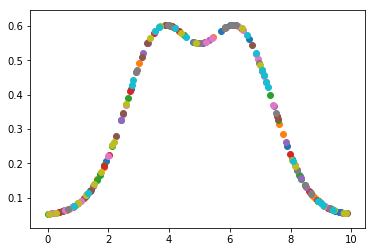

In [67]:
generator = BatchGenerator(20)

figg = plt.figure()
sp = figg.add_subplot(111)

for i in range(10):
  x, y = generator.spit()

  sp.scatter(x, y)
plt.show()

Generate valid and test datasets:

Test size: %s (120, 1)
Ten test pairs as an example:
Time 0:7:23 (443th second) => 54.16 rps
Time 0:13:47 (827th second) => 54.65 rps
Time 0:19:24 (1164th second) => 55.12 rps
Time 0:26:12 (1572th second) => 55.75 rps
Time 0:30:1 (1801th second) => 56.13 rps
Time 0:42:29 (2549th second) => 57.54 rps
Time 0:49:47 (2987th second) => 58.49 rps
Time 1:5:18 (3918th second) => 60.89 rps
Time 1:16:17 (4577th second) => 62.92 rps
Time 1:53:37 (6817th second) => 72.56 rps


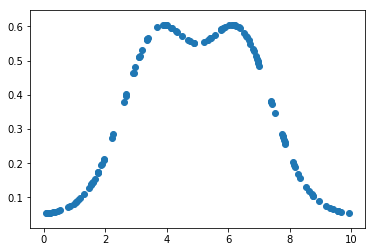

In [4]:
# Test dataset
test_dataset, test_labels = generator.spit()
# sort it for a nice view
sorting = np.array([test_dataset, test_labels]).reshape(2, -1).T
sorting = sorting[np.argsort(sorting[:, 0])]
test_dataset, test_labels = sorting.T.reshape(2, -1, 1)

print('Test size: %s', test_dataset.shape)
print('Ten test pairs as an example:')

for sec, label in list(zip(test_dataset, test_labels))[:10]:
  print('Time %s => %03.2f rps' % (squashed_secs_to_string(sec), squashed_label_to_label(label)))
  
plt.scatter(test_dataset, test_labels)
plt.show()

Simple NN Model with one hidden layer and ReLU activation function.

In [60]:
feature_size = 1 # number of features to feed input
num_labels = 1 # number of output labels
num_hidden_nodes = 8
num_hidden_nodes2 = 16
num_hidden_nodes3 = 8
batch_size = 100

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  x = tf.placeholder(tf.float32, shape=(batch_size, feature_size))
  y = tf.placeholder(tf.float32, shape=(batch_size, 1))
  tf_test_data = tf.placeholder(tf.float32, shape=(None, feature_size))

  # Hidden layer variables
  weights1 = tf.Variable(tf.truncated_normal([feature_size, num_hidden_nodes]))
  biases1  = tf.Variable(tf.zeros([num_hidden_nodes]))

  weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_hidden_nodes2]))
  biases2  = tf.Variable(tf.zeros([num_hidden_nodes2]))
  
  weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3]))
  biases3  = tf.Variable(tf.zeros([num_hidden_nodes3]))

  # Variables.
  weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels]))
  biases4  = tf.Variable(tf.zeros([num_labels]))
  tf_global_step = tf.Variable(0)  # count the number of steps taken

  # Training computation.
  z0 = tf.matmul(x, weights1) + biases1
  a0 = tf.nn.sigmoid(z0)
  
  z1 = tf.matmul(a0, weights2) + biases2
  a1 = tf.nn.sigmoid(z1)
  
  z2 = tf.matmul(a1, weights3) + biases3
  a2 = tf.nn.sigmoid(z2)

  z3 = tf.matmul(a2, weights4) + biases4
  a3 = z3
  error = a3 - y
  loss = tf.reduce_mean(tf.square(error))

  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, tf_global_step, 7000, 0.98, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=tf_global_step)

  # Prediction for test data.
  tf_prediction_hidden = tf.nn.sigmoid(tf.matmul(tf_test_data, weights1) + biases1)
  tf_prediction_hidden2 = tf.nn.sigmoid(tf.matmul(tf_prediction_hidden, weights2) + biases2)
  tf_prediction_hidden3 = tf.nn.sigmoid(tf.matmul(tf_prediction_hidden2, weights3) + biases3)
  tf_prediction        = tf.matmul(tf_prediction_hidden3, weights4) + biases4

In [61]:
num_steps = 100051
generator = BatchGenerator(batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      batch_data, batch_labels = generator.spit()
      feed_dict = {x : batch_data, y : batch_labels}
      _, l, global_step, lr = session.run(
        [optimizer, loss, tf_global_step, learning_rate], feed_dict=feed_dict)

      if (step % 1000 == 0):
        print("Minibatch loss at step %d: %f, learning rate: %f" % (global_step, l, lr))
    predicted = tf_prediction.eval(feed_dict={tf_test_data: test_dataset})

session.close()

Initialized
Minibatch loss at step 1: 1.650612, learning rate: 0.500000
Minibatch loss at step 1001: 0.023338, learning rate: 0.500000
Minibatch loss at step 2001: 0.016084, learning rate: 0.500000
Minibatch loss at step 3001: 0.016544, learning rate: 0.500000
Minibatch loss at step 4001: 0.010330, learning rate: 0.500000
Minibatch loss at step 5001: 0.004964, learning rate: 0.500000
Minibatch loss at step 6001: 0.003880, learning rate: 0.500000
Minibatch loss at step 7001: 0.001471, learning rate: 0.490000
Minibatch loss at step 8001: 0.001206, learning rate: 0.490000
Minibatch loss at step 9001: 0.001133, learning rate: 0.490000
Minibatch loss at step 10001: 0.001214, learning rate: 0.490000
Minibatch loss at step 11001: 0.001114, learning rate: 0.490000
Minibatch loss at step 12001: 0.001061, learning rate: 0.490000
Minibatch loss at step 13001: 0.001044, learning rate: 0.490000
Minibatch loss at step 14001: 0.001201, learning rate: 0.480200
Minibatch loss at step 15001: 0.001029, l

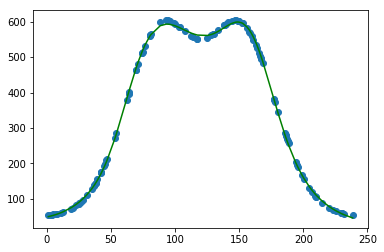

In [62]:
predicted_test = np.array(squashed_labels_to_labels(predicted.reshape(predicted.shape[0])))

plt.scatter(squashed_secs_to_hours(test_dataset), squashed_labels_to_labels(test_labels))
plt.plot(squashed_secs_to_hours(test_dataset), predicted_test, color='green')
plt.show()